In [4]:
import torch
import os
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from softmax import SoftmaxModel
import collections
from scipy.ndimage import gaussian_filter, convolve
import time
from dataloaders import train_dataloader, test_dataloader
from torch import nn, optim
from scipy.ndimage import gaussian_filter, convolve
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import normalized_root_mse as nrmse
from skimage.metrics import structural_similarity as ssm
from utils import classes, c_to_i, get_orig, show_images

In [6]:
TRAIN_DIR = './data/processed/train/'
TEST_DIR = './data/processed/test/'

classes = os.listdir(TRAIN_DIR)
c_to_i = lambda x: classes.index(x)
i_to_c = lambda x: classes[x]

transformer = transforms.Compose([
    transforms.ToTensor(),
])

def show_img(im):
    plt.imshow(im.reshape(112, 92) / 2 + .5, cmap='gray')
    plt.show()
    
def one_hot(x):
    vec = [0] *len(classes)
    vec[x] = 1
    return vec
    
train =test= 0
train_x, train_y = ([0]) * 280, ([0]) * 280
test_x, test_y = ([0]) * 120, ([0]) * 120
asd = []

for c in os.listdir(TRAIN_DIR):
    for faces in os.listdir(TRAIN_DIR+c):
        img = np.array(Image.open(TRAIN_DIR+c+'/'+faces).convert('L'))
        train_x[train] = (img).flatten()
        train_y[train] = (c_to_i(c))
        train += 1

for c in os.listdir(TEST_DIR):
    for faces in os.listdir(TEST_DIR+c):
        img = np.array(Image.open(TEST_DIR+c+'/'+faces).convert('L'))
        test_x[test] = img.flatten()
        test_y[test] = (c_to_i(c))
        test += 1

train_x = np.stack([x.flatten() for x in train_x])
test_x = np.stack([x.flatten() for x in test_x])
test_y = np.array(test_y,  dtype=np.int64)
train_y = np.array(train_y, dtype=np.int64)

### Models

In [7]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.name = "MLP"
        self.linear1 = nn.Linear(10304, 3000)
        torch.manual_seed(666)
        torch.nn.init.normal_(self.linear1.weight)
        self.linear2 = nn.Linear(3000, 40)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.sigmoid(self.linear1(x))
        x = self.linear2(x)
        return x

In [8]:
def buildModel(model, lRate, plot=False, verbose=False):

    startTime = time.time()
    timeStr = time.strftime("%H:%M:%S", time.localtime(startTime))
    print("Starting at " + timeStr + " to build " + model.name + " model...")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lRate)
    train_losses, validate_losses, accuracy_data = [], [], []
    valid_loss_min = np.Inf
    
    best_accuracy = 0
    iteration_count = 0
    total_iteration = 0
    
    # as in the paper, if there is no improvment after 100 iterations
    # stop training
    while iteration_count < 100:
        total_iteration += 1
        if (total_iteration%100==0): print("epoch: " + str(total_iteration))
        running_loss = 0
        for images, labels in train_dataloader:
            output = model(images)
            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        # epoch over
        iteration_count +=1
        
        validate_loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in test_dataloader:
                samples = model(images)
                pred = samples.argmax(dim=1)
                accuracy = (pred == labels).sum().item() / len(labels)
                
            model.train()
            train_loss = running_loss / len(train_dataloader)
            train_losses.append(train_loss)
            accuracy_data.append(accuracy)
            
            
            if accuracy > best_accuracy:  # if we improve our accuracy, set the iteration count to 0
                if verbose:
                    print("Epoch: {}.. ".format(total_iteration))
                    print('Accuracy increased ({:.2f} --> {:.2f}). Saving model ...'.format(
                        best_accuracy, accuracy))
                torch.save(model.state_dict(), './models/'+model.name+"_model.pt")
                iteration_count = 0
                best_accuracy = accuracy  # update best accuracy

    endTime = time.time()
    dur = endTime - startTime
    timeStr = time.strftime("%H:%M:%S", time.localtime(endTime))
    print("Finished at " + timeStr + ", duration in sec: " + str(int(dur)))
    print("Total number of iterations ", total_iteration,", with accuracy of ", best_accuracy)
    return model

In [9]:
mlp = buildModel(MLP(), 0.1, True, True)

Starting at 14:42:29 to build MLP model...


C:\Users\a793954\Anaconda3\lib\site-packages\torch\nn\functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 3.. 
Accuracy increased (0.00 --> 0.40). Saving model ...
Epoch: 5.. 
Accuracy increased (0.40 --> 0.90). Saving model ...
Epoch: 7.. 
Accuracy increased (0.90 --> 1.00). Saving model ...
epoch: 100
Finished at 14:57:25, duration in sec: 896
Total number of iterations  107 , with accuracy of  1.0


### Reconstruction attack

In [48]:
# values from paper with adjusted gamma and cost function
alpha = 5000
beta = 100
gamma = 0.1
delta = 0.1

# returns a vector with all costs for all labels
def my_cost(pred):
    cost = torch.ones(pred.shape) - pred
    return cost    

In [54]:
def invert(model, img, criterion, optimizer, lr, c, best_cost, best_x, i, b, beta, gamma):
    img = torch.Tensor(img).view(1, -1)
    if not img.requires_grad:
        img.requires_grad = True
        
    optimizer.zero_grad()
    pred = model(img)
    b -= 1

    
    # calculate cost
    cost = my_cost(F.softmax(pred))
    cost = cost.detach().numpy().flatten()[c]
    
    # calculate loss
    loss = criterion(pred, torch.LongTensor([c]))
    loss.backward()  
    
    img = torch.clamp(img - lr * img.grad, 0, 255)
    np_a = np.array([np.clip(x + np.random.normal(2, 2),0,255) for x in img.detach().numpy()])
    
    if cost < best_cost:
        print("Cost was updated, is now", cost,"was", best_cost)
        best_cost = cost
        best_x = img.detach().numpy()
        b = beta
    
    if cost >= best_cost and b <= 0:
        print("Cost doesn't improve after", beta, "iterations with a best value of", best_cost)
        best_cost = cost
        best_x = img.detach().numpy()
        return best_cost, best_x, b, np_a.reshape(1, -1), True
    
    if cost <= gamma:
        print("Cost is lower than gamma with a value of ", cost)
        best_cost = cost
        best_x = img.detach().numpy()
        return best_cost, best_x, b, np_a.reshape(1, -1), True
    
    return best_cost, best_x, b, np_a.reshape(1, -1), False

<ipython-input-54-45fe293a0497>:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cost = my_cost(F.softmax(pred))


Cost was updated, is now 0.998133 was 1
Cost was updated, is now 0.87153876 was 0.998133
Cost was updated, is now 6.389618e-05 was 0.87153876
Cost is lower than gamma with a value of  6.389618e-05


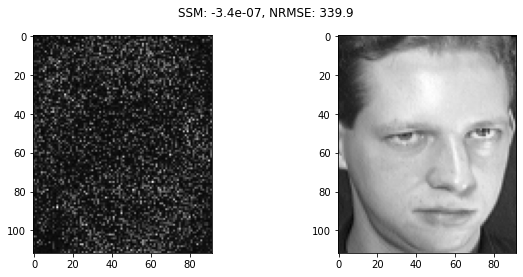

Cost was updated, is now 0.8421838 was 1
Cost doesn't improve after 100 iterations with a best value of 0.8421838


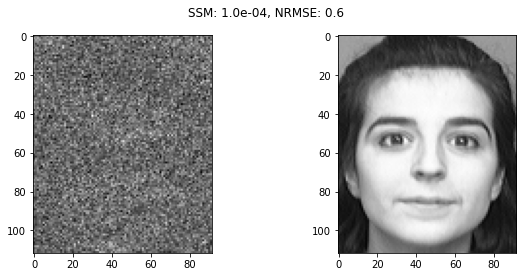

Cost was updated, is now 0.8658707 was 1
Cost was updated, is now 0.0 was 0.8658707
Cost is lower than gamma with a value of  0.0


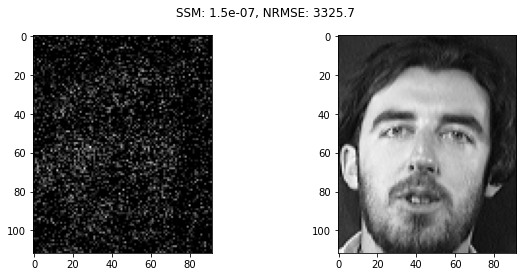

Cost was updated, is now 0.9969736 was 1
Cost doesn't improve after 100 iterations with a best value of 0.9969736


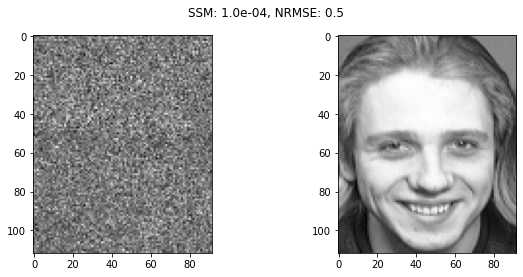

Cost was updated, is now 0.9997465 was 1
Cost was updated, is now 0.8336773 was 0.9997465
Cost was updated, is now 0.76959646 was 0.8336773
Cost doesn't improve after 100 iterations with a best value of 0.76959646


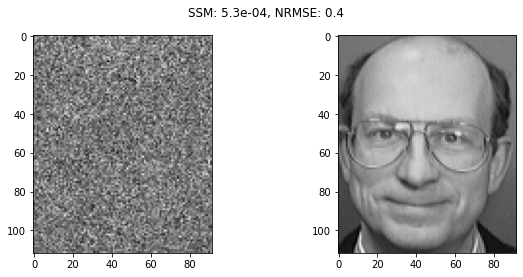

Cost was updated, is now 0.963297 was 1
Cost doesn't improve after 100 iterations with a best value of 0.963297


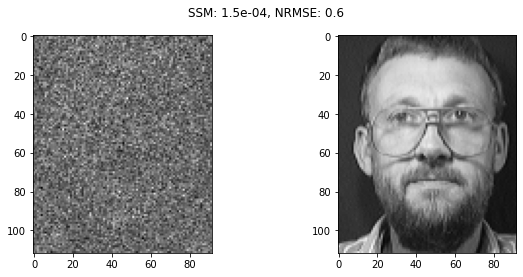

Cost was updated, is now 0.9995101 was 1
Cost was updated, is now 0.99182653 was 0.9995101
Cost was updated, is now 0.9900805 was 0.99182653
Cost doesn't improve after 100 iterations with a best value of 0.9900805


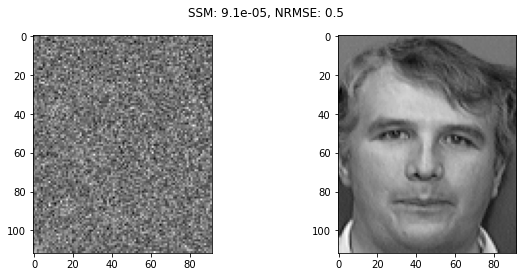

Cost was updated, is now 0.979585 was 1
Cost was updated, is now 0.00048208237 was 0.979585
Cost is lower than gamma with a value of  0.00048208237


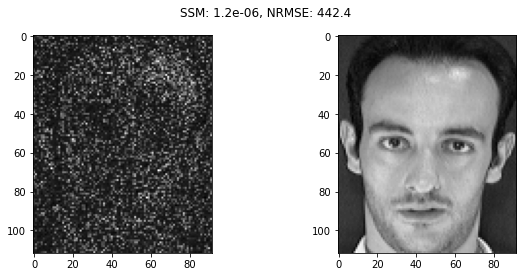

Cost was updated, is now 0.9957789 was 1
Cost doesn't improve after 100 iterations with a best value of 0.9957789


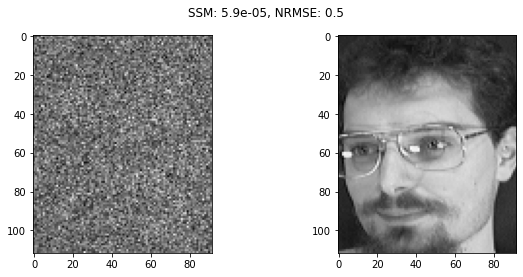

Cost was updated, is now 0.9998774 was 1
Cost was updated, is now 0.04259461 was 0.9998774
Cost is lower than gamma with a value of  0.04259461


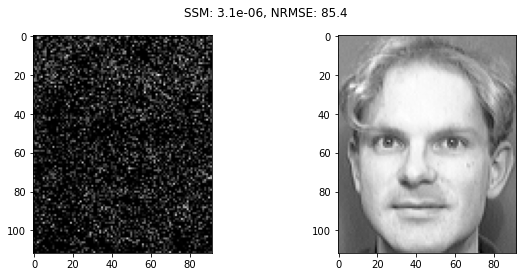

Cost was updated, is now 0.9998144 was 1
Cost doesn't improve after 100 iterations with a best value of 0.9998144


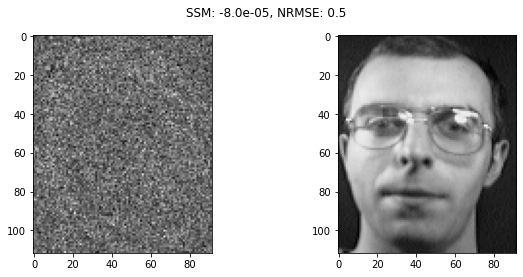

Cost was updated, is now 0.993677 was 1
Cost doesn't improve after 100 iterations with a best value of 0.993677


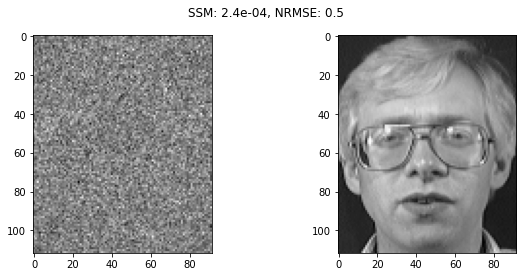

Cost was updated, is now 0.9830571 was 1
Cost was updated, is now 0.36234212 was 0.9830571
Cost doesn't improve after 100 iterations with a best value of 0.36234212


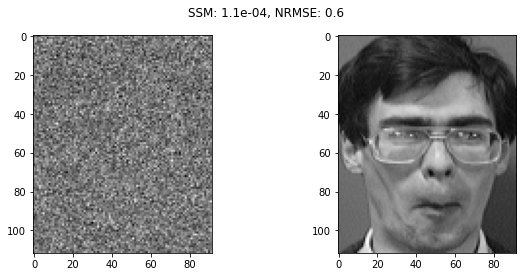

Cost was updated, is now 0.9983186 was 1
Cost was updated, is now 0.98991555 was 0.9983186
Cost was updated, is now 0.8850206 was 0.98991555
Cost doesn't improve after 100 iterations with a best value of 0.8850206


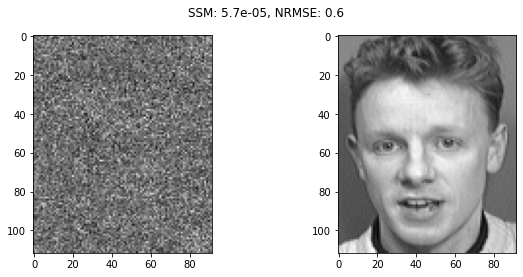

Cost was updated, is now 0.9937 was 1
Cost doesn't improve after 100 iterations with a best value of 0.9937


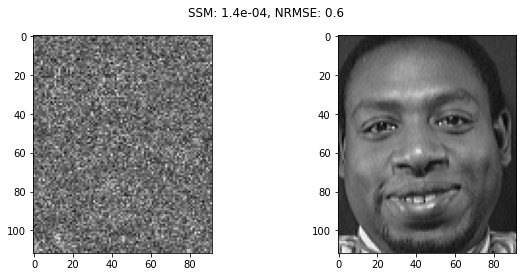

Cost was updated, is now 0.9831416 was 1
Cost was updated, is now 0.89677715 was 0.9831416
Cost doesn't improve after 100 iterations with a best value of 0.89677715


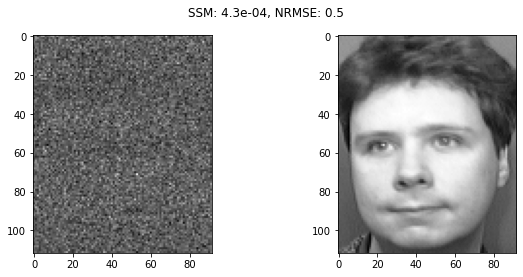

Cost was updated, is now 0.9995298 was 1
Cost was updated, is now 7.1525574e-07 was 0.9995298
Cost is lower than gamma with a value of  7.1525574e-07


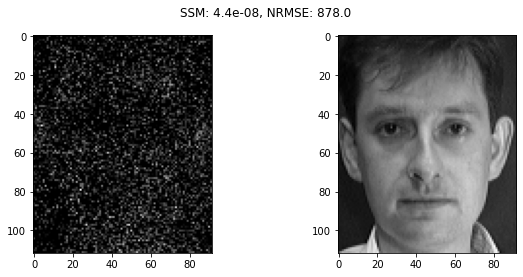

Cost was updated, is now 0.9999124 was 1
Cost was updated, is now 0.9771465 was 0.9999124
Cost was updated, is now 0.9686727 was 0.9771465
Cost was updated, is now 0.9612341 was 0.9686727
Cost doesn't improve after 100 iterations with a best value of 0.9612341


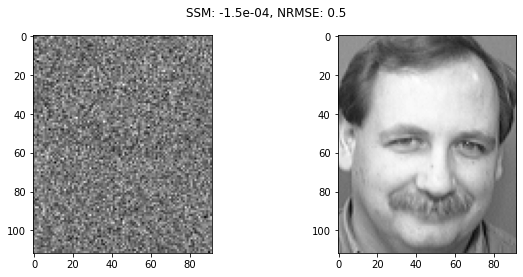

Cost was updated, is now 0.99537885 was 1
Cost was updated, is now 0.0004312396 was 0.99537885
Cost is lower than gamma with a value of  0.0004312396


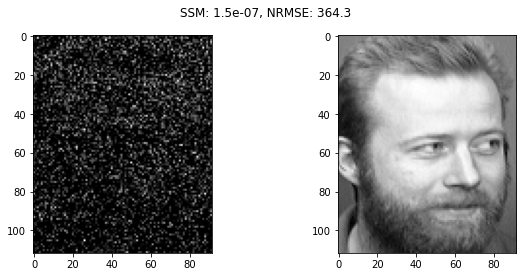

Cost was updated, is now 0.9988782 was 1
Cost doesn't improve after 100 iterations with a best value of 0.9988782


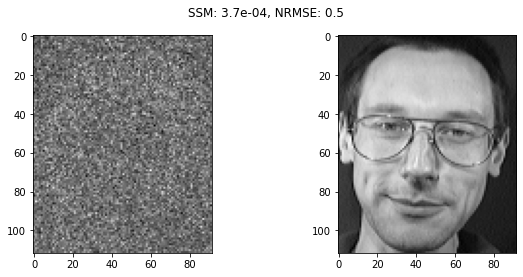

Cost was updated, is now 0.9953115 was 1
Cost doesn't improve after 100 iterations with a best value of 0.9953115


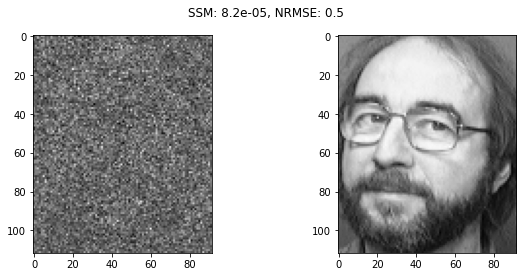

Cost was updated, is now 0.99704313 was 1
Cost was updated, is now 0.99457926 was 0.99704313
Cost was updated, is now 0.9944712 was 0.99457926
Cost was updated, is now 0.9944033 was 0.9944712
Cost was updated, is now 0.9943342 was 0.9944033
Cost was updated, is now 0.99430656 was 0.9943342
Cost doesn't improve after 100 iterations with a best value of 0.99430656


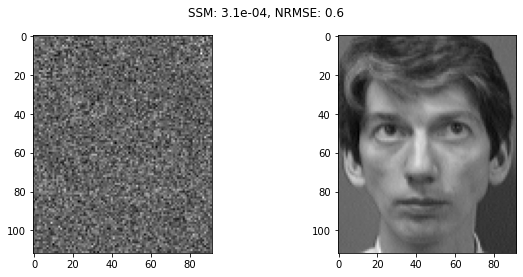

Cost was updated, is now 0.9998641 was 1
Cost was updated, is now 0.9997544 was 0.9998641
Cost was updated, is now 0.99000615 was 0.9997544
Cost doesn't improve after 100 iterations with a best value of 0.99000615


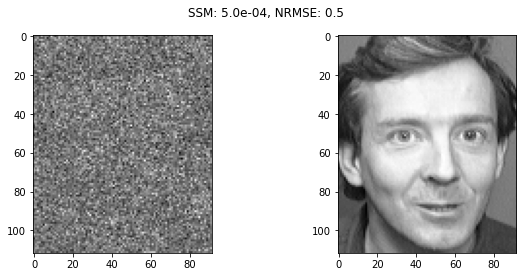

Cost was updated, is now 0.99534404 was 1
Cost was updated, is now 0.9952432 was 0.99534404
Cost doesn't improve after 100 iterations with a best value of 0.9952432


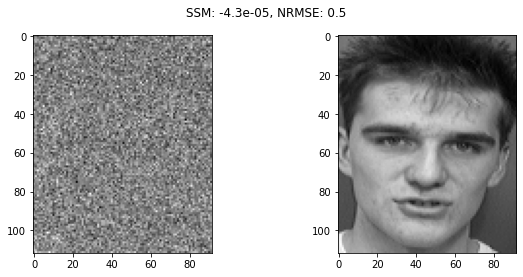

Cost was updated, is now 0.9503318 was 1
Cost was updated, is now 0.6794944 was 0.9503318
Cost doesn't improve after 100 iterations with a best value of 0.6794944


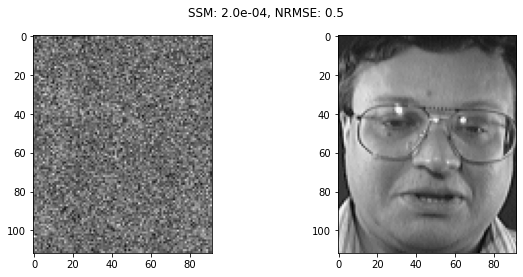

Cost was updated, is now 0.99442536 was 1
Cost was updated, is now 0.6712572 was 0.99442536
Cost was updated, is now 0.6313101 was 0.6712572
Cost was updated, is now 0.6272819 was 0.6313101
Cost was updated, is now 0.6268493 was 0.6272819
Cost doesn't improve after 100 iterations with a best value of 0.6268493


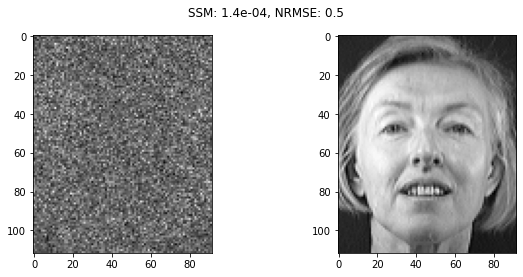

Cost was updated, is now 0.82789296 was 1
Cost doesn't improve after 100 iterations with a best value of 0.82789296


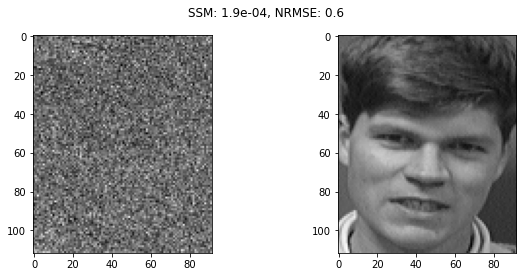

Cost was updated, is now 0.75932944 was 1
Cost was updated, is now 0.72220105 was 0.75932944
Cost doesn't improve after 100 iterations with a best value of 0.72220105


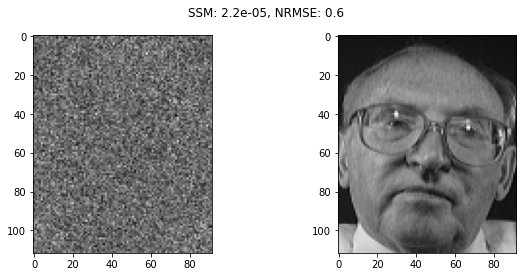

Cost was updated, is now 0.9956422 was 1
Cost was updated, is now 0.672083 was 0.9956422
Cost was updated, is now 0.63860786 was 0.672083
Cost was updated, is now 0.6348535 was 0.63860786
Cost doesn't improve after 100 iterations with a best value of 0.6348535


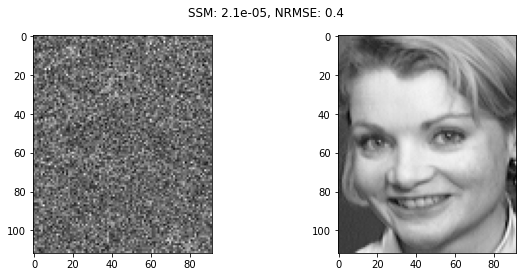

Cost was updated, is now 0.9839919 was 1
Cost doesn't improve after 100 iterations with a best value of 0.9839919


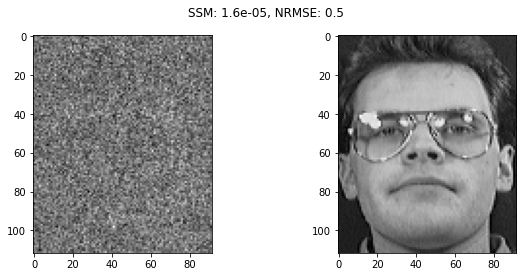

Cost was updated, is now 0.95657974 was 1
Cost was updated, is now 0.94432586 was 0.95657974
Cost doesn't improve after 100 iterations with a best value of 0.94432586


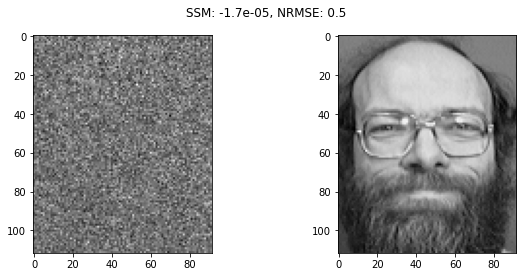

Cost was updated, is now 0.99608296 was 1
Cost doesn't improve after 100 iterations with a best value of 0.99608296


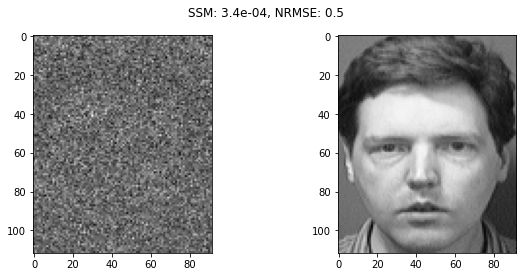

Cost was updated, is now 0.97657377 was 1
Cost was updated, is now 0.0019964576 was 0.97657377
Cost is lower than gamma with a value of  0.0019964576


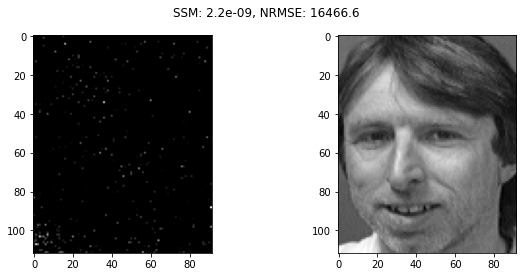

Cost was updated, is now 0.9997168 was 1
Cost was updated, is now 1.5258789e-05 was 0.9997168
Cost is lower than gamma with a value of  1.5258789e-05


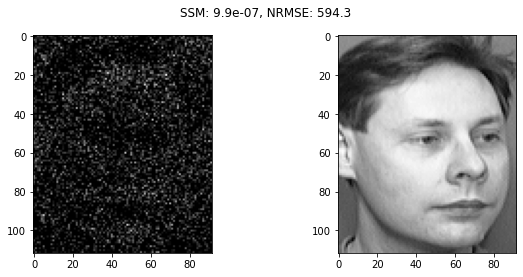

Cost was updated, is now 0.9995184 was 1
Cost was updated, is now 0.09230995 was 0.9995184
Cost is lower than gamma with a value of  0.09230995


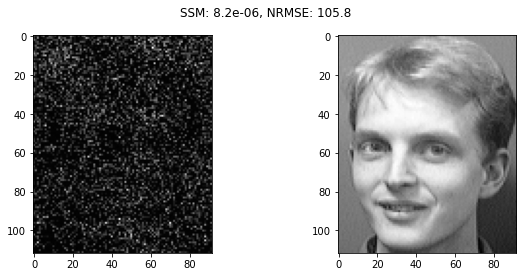

Cost was updated, is now 0.99995357 was 1
Cost was updated, is now 0.17114931 was 0.99995357
Cost doesn't improve after 100 iterations with a best value of 0.17114931


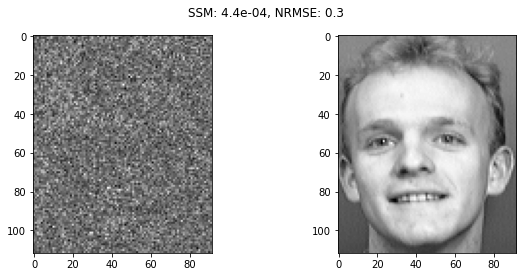

Cost was updated, is now 0.9988016 was 1
Cost was updated, is now 0.044208646 was 0.9988016
Cost is lower than gamma with a value of  0.044208646


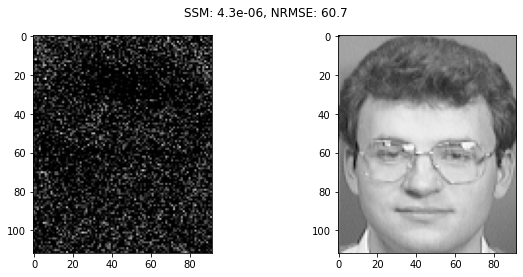

Cost was updated, is now 0.9883068 was 1
Cost doesn't improve after 100 iterations with a best value of 0.9883068


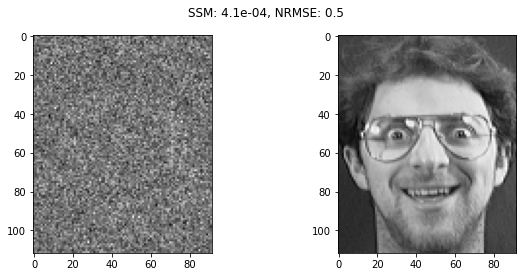

Cost was updated, is now 0.9990049 was 1
Cost doesn't improve after 100 iterations with a best value of 0.9990049


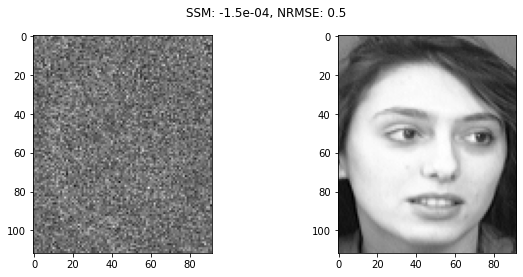

Cost was updated, is now 0.9999207 was 1
Cost doesn't improve after 100 iterations with a best value of 0.9999207


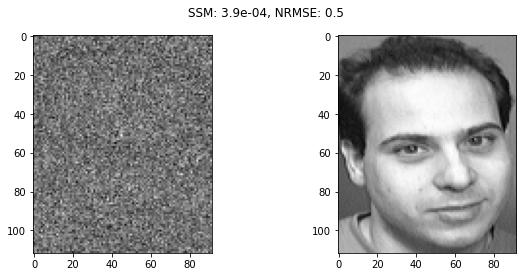

Duration in sec: 634


In [55]:
startTime = time.time()
timeStr = time.strftime("%H:%M:%S", time.localtime(startTime))
show = True
save = True
mse_all, nrmsev_all, ssmv_all, epochs = [],[],[],[]
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mlp.parameters(), lr=delta)
test_x = get_orig()
rec_x = np.zeros((40,112,92), dtype='float32')

for c in classes:
    best_x,best_cost='',1
    img = np.zeros_like(test_x[0])
    b = beta
    for i in range(alpha):
        best_cost, best_x, b, img, stop = invert(mlp, img, criterion, optimizer, 
                                              delta, c_to_i(c), best_cost, best_x, i, 
                                              b, beta, gamma)
        if stop:
            epochs.append(i)
            break
    orig = test_x[c_to_i(c)]
    rec = best_x.reshape(112, 92)
    rec_x[c_to_i(c)] = rec
    ssmv = ssm(rec,orig)
    msev = mse(rec,orig)
    nrmsev = nrmse(rec,orig)
    mse_all.append(msev)
    nrmsev_all.append(nrmsev)
    ssmv_all.append(ssmv)
    
    if (show or save):
        fig = plt.figure(figsize=(10, 4))
        fig.suptitle("SSM: {:.1e}, NRMSE: {:.1f}".format(ssmv,nrmsev))
        ax1 = fig.add_subplot(1,2,1)
        ax1.imshow(rec, cmap='gray')
        ax2 = fig.add_subplot(1,2,2)
        ax2.imshow(orig, cmap='gray')
        if save:
            plt.savefig(f'./data/results/class_{c}.png')
        if show:
            plt.show()
        
endTime = time.time()
dur = endTime - startTime
print("Duration in sec: " + str(int(dur)))

In [56]:
# Calculating means performance values of all images
print('MSE mean',np.mean(mse_all))
print('NRMSE mean',np.mean(nrmsev_all))
print('SSM mean',np.mean(ssmv_all))
print('Epochs mean',np.mean(epochs))

MSE mean 12668.868039789159
NRMSE mean 566.9678196637394
SSM mean 0.00012513249771285655
Epochs mean 76.375
